# NBA Game Prediction - Data Wrangling

This notebook prepares the data for modeling NBA game outcomes. We'll:
1. Load game data from `team_traditional.csv`
2. Calculate rolling features (last 10 games) - **no data leakage**
3. Create matchup dataset (home vs away)
4. Save processed data for modeling

**Key principle**: Only use data available BEFORE each game (point-in-time features)

## 1. Setup and Load Data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

print("Packages loaded successfully!")


Packages loaded successfully!


In [2]:
# Load game data
games = pd.read_csv('team_traditional.csv')

# Convert date to datetime and sort by team and date
games['date'] = pd.to_datetime(games['date'])
#games = games.sort_values(['team', 'date']).reset_index(drop=True)

print(f"Loaded {len(games):,} games")
print(f"Date range: {games['date'].min().date()} to {games['date'].max().date()}")
print(f"Teams: {games['team'].nunique()}")
print(f"Seasons: {games['season'].nunique()}")


Loaded 70,850 games
Date range: 1996-11-01 to 2025-06-22
Teams: 36
Seasons: 28


In [3]:
# Preview the data
print("Sample of raw data:")
games.head(10)


Sample of raw data:


,gameid,date,type,teamid,team,home,away,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,+/-,win,season
0,29600001,1996-11-01,regular,1610612738,BOS,BOS,CHI,48.0,98.0,38.0,84.0,45.2,8.0,20.0,40.0,14.0,23.0,60.9,14.0,22.0,36.0,20.0,18.0,10.0,2.0,33.0,-9.0,0.0,1997
1,29600001,1996-11-01,regular,1610612741,CHI,BOS,CHI,48.0,107.0,42.0,74.0,56.8,1.0,13.0,7.7,22.0,32.0,68.8,8.0,29.0,37.0,28.0,19.0,7.0,8.0,23.0,9.0,1.0,1997
2,29600002,1996-11-01,regular,1610612739,CLE,NJN,CLE,48.0,90.0,34.0,72.0,47.2,5.0,10.0,50.0,17.0,20.0,85.0,12.0,23.0,35.0,16.0,15.0,11.0,1.0,24.0,13.0,1.0,1997
3,29600002,1996-11-01,regular,1610612751,NJN,NJN,CLE,48.0,77.0,23.0,58.0,39.7,9.0,18.0,50.0,22.0,33.0,66.7,11.0,24.0,35.0,13.0,22.0,7.0,7.0,19.0,-13.0,0.0,1997
4,29600003,1996-11-01,regular,1610612749,MIL,PHI,MIL,48.0,111.0,38.0,84.0,45.2,4.0,9.0,44.4,31.0,44.0,70.5,19.0,31.0,50.0,21.0,15.0,9.0,7.0,30.0,8.0,1.0,1997
5,29600003,1996-11-01,regular,1610612755,PHI,PHI,MIL,48.0,103.0,37.0,83.0,44.6,2.0,10.0,20.0,27.0,36.0,75.0,14.0,26.0,40.0,25.0,14.0,6.0,4.0,29.0,-8.0,0.0,1997
6,29600004,1996-11-01,regular,1610612753,ORL,ORL,WAS,48.0,92.0,35.0,91.0,38.5,5.0,23.0,21.7,17.0,20.0,85.0,22.0,26.0,48.0,17.0,17.0,7.0,3.0,22.0,-4.0,0.0,1997
7,29600004,1996-11-01,regular,1610612764,WAS,ORL,WAS,48.0,96.0,35.0,74.0,47.3,4.0,13.0,30.8,22.0,30.0,73.3,11.0,26.0,37.0,25.0,16.0,10.0,10.0,24.0,4.0,1.0,1997
8,29600005,1996-11-01,regular,1610612737,ATL,MIA,ATL,48.0,81.0,25.0,65.0,38.5,4.0,16.0,25.0,27.0,32.0,84.4,10.0,30.0,40.0,13.0,24.0,10.0,7.0,20.0,-13.0,0.0,1997
9,29600005,1996-11-01,regular,1610612748,MIA,MIA,ATL,48.0,94.0,35.0,78.0,44.9,10.0,21.0,47.6,14.0,19.0,73.7,13.0,27.0,40.0,26.0,19.0,8.0,4.0,25.0,13.0,1.0,1997


In [4]:
# Check for missing values
print("Missing values per column:")
print(games.isnull().sum()[games.isnull().sum() > 0])


Missing values per column:
Series([], dtype: int64)


In [5]:
# Calculate opponent points (each game has 2 rows, need to match opponents)
print("Calculating opponent points...")

# For each game, get the opponent's score
# Games have 2 rows per gameid - match them to find opponent's PTS so that each row has both that team's and the opponent's points
opp_pts = games.groupby('gameid')['PTS'].transform(lambda x: x.iloc[::-1].values)
games['opp_pts'] = opp_pts

print(f"✓ Opponent points calculated")
print(f"Sample check - first game:")
print(games[['team', 'PTS', 'opp_pts', '+/-']].head(20))


Calculating opponent points...
✓ Opponent points calculated
Sample check - first game:
   team    PTS  opp_pts   +/-
0   BOS   98.0    107.0  -9.0
1   CHI  107.0     98.0   9.0
2   CLE   90.0     77.0  13.0
3   NJN   77.0     90.0 -13.0
4   MIL  111.0    103.0   8.0
5   PHI  103.0    111.0  -8.0
6   ORL   92.0     96.0  -4.0
7   WAS   96.0     92.0   4.0
8   ATL   81.0     94.0 -13.0
9   MIA   94.0     81.0  13.0
10  NYK  107.0     99.0   8.0
11  TOR   99.0    107.0  -8.0
12  DET   95.0     89.0   6.0
13  IND   89.0     95.0  -6.0
14  MIN   82.0     78.0   4.0
15  SAS   78.0     82.0  -4.0
16  HOU   96.0     85.0  11.0
17  SAC   85.0     96.0 -13.0
18  DAL   92.0     91.0   1.0
19  DEN   91.0     92.0  -1.0


## 2. Calculate Rolling Features (Last 10 Games)

**Critical**: We use `.shift(1)` to ensure we only use games BEFORE the current one.  
This prevents data leakage - we can't use today's game stats to predict today's game!

**Features we're calculating:**
- **Tier 1**: pts, fg%, 3p%, opp_pts, win_pct, plus_minus, rest_days, is_b2b
- **Tier 2**: efg%, ts%, 3pa_rate, ast, tov, reb, stl, blk, pts_std, win_streak


In [6]:
#Next step is to calculate chronolgical rolling features per team, so we should sort to be safe (want to make sure prior 10 are actually the prior 10 games sequentially)
games = games.sort_values(['team', 'season', 'date']).reset_index(drop=True)
print(games.head(20))

      gameid       date     type      teamid team home away   MIN    PTS   FGM   FGA   FG%   3PM   3PA   3P%   FTM  \
0   29600005 1996-11-01  regular  1610612737  ATL  MIA  ATL  48.0   81.0  25.0  65.0  38.5   4.0  16.0  25.0  27.0   
1   29600017 1996-11-02  regular  1610612737  ATL  ATL  DET  48.0   78.0  29.0  72.0  40.3   8.0  24.0  33.3  12.0   
2   29600030 1996-11-04  regular  1610612737  ATL  POR  ATL  48.0   94.0  32.0  74.0  43.2  11.0  17.0  64.7  19.0   
3   29600040 1996-11-05  regular  1610612737  ATL  SEA  ATL  48.0  117.0  43.0  82.0  52.4  16.0  29.0  55.2  15.0   
4   29600051 1996-11-07  regular  1610612737  ATL  SAC  ATL  48.0   91.0  32.0  74.0  43.2   4.0  18.0  22.2  23.0   
5   29600072 1996-11-10  regular  1610612737  ATL  LAL  ATL  48.0   85.0  30.0  84.0  35.7  10.0  30.0  33.3  15.0   
6   29600082 1996-11-12  regular  1610612737  ATL  ATL  CLE  48.0   87.0  32.0  76.0  42.1   7.0  22.0  31.8  16.0   
7   29600089 1996-11-13  regular  1610612737  ATL  BOS  

In [7]:
# Helper function to calculate rolling averages (reduces repetition)
def rolling_avg(df, column, window=10, stat='mean'):
    """Calculate rolling average for a column, excluding current game"""
    grouped = df.groupby(['team', 'season'])[column].rolling(window, min_periods=1 if stat == 'mean' else 2) #rolls back 10 games for a given team, with min 1-2 games needed to calculate
    
    if stat == 'mean':
        result = grouped.mean()
    elif stat == 'std':
        result = grouped.std()
    result = result.groupby(level=['team', 'season']).shift(1) #shift 1 down within each team-season to exclude current game
    return result.reset_index(level = ['team', 'season'], drop=True)

# Calculate rolling features
window = 10
print(f"Calculating rolling features (last {window} games)...")

# TIER 1: Core offensive stats
games['pts_L10'] = rolling_avg(games, 'PTS', window)
games['fg_pct_L10'] = rolling_avg(games, 'FG%', window)
games['3p_pct_L10'] = rolling_avg(games, '3P%', window)

# TIER 1: Defensive stats
games['opp_pts_L10'] = rolling_avg(games, 'opp_pts', window)

# TIER 1: Form/momentum
games['win_pct_L10'] = rolling_avg(games, 'win', window)
games['plus_minus_L10'] = rolling_avg(games, '+/-', window)

# TIER 2: Advanced shooting (calculate derived stats first)
games['eFG%'] = (games['FGM'] + 0.5 * games['3PM']) / games['FGA']
games['TS%'] = games['PTS'] / (2 * (games['FGA'] + 0.44 * games['FTA']))
games['3PA_rate'] = games['3PA'] / games['FGA']

games['efg_pct_L10'] = rolling_avg(games, 'eFG%', window)
games['ts_pct_L10'] = rolling_avg(games, 'TS%', window)
games['3pa_rate_L10'] = rolling_avg(games, '3PA_rate', window)

# TIER 2: Playmaking
games['ast_L10'] = rolling_avg(games, 'AST', window)
games['tov_L10'] = rolling_avg(games, 'TOV', window)

# TIER 2: Rebounding
games['reb_L10'] = rolling_avg(games, 'REB', window)

# TIER 2: Defense details
games['stl_L10'] = rolling_avg(games, 'STL', window)
games['blk_L10'] = rolling_avg(games, 'BLK', window)

# TIER 2: Consistency (point volatility - use std instead of mean)
games['pts_std_L10'] = rolling_avg(games, 'PTS', window, stat='std')

print("✓ Rolling features calculated (Tier 1 + Tier 2)")


Calculating rolling features (last 10 games)...
✓ Rolling features calculated (Tier 1 + Tier 2)


In [8]:
# Calculate contextual features
print("Calculating contextual features...")

# TIER 1: Rest days since last game
games['rest_days'] = games.groupby(['team', 'season'])['date'].diff().dt.days

# TIER 1: Back-to-back indicator (1 if playing on consecutive days)
games['is_b2b'] = (games['rest_days'] <= 1).astype(int)

# Game number in season
games['game_num'] = games.groupby(['team', 'season']).cumcount() + 1

# TIER 2: Win streak (positive for wins, negative for losses)
def calculate_win_streak(series):
    """Calculate current win/loss streak"""
    streaks = []
    for i in range(len(series)):
        if i == 0:
            streaks.append(0)
        else:
            recent_wins = series[:i]  # Only past games
            if len(recent_wins) == 0:
                streaks.append(0)
            else:
                current = recent_wins.iloc[-1]
                streak = 0
                for j in range(len(recent_wins)-1, -1, -1):
                    if recent_wins.iloc[j] == current:
                        streak += 1
                    else:
                        break
                streaks.append(streak if current == 1 else -streak)
    return streaks

games['win_streak'] = games.groupby(['team', 'season'])['win'].transform(calculate_win_streak)

print("✓ Contextual features calculated (including win streaks)")


Calculating contextual features...
✓ Contextual features calculated (including win streaks)


In [9]:
# Check if every gameid has exactly 2 rows
games_per_id = games.groupby('gameid').size()
print(f"\nGames with != 2 rows:")
print(games_per_id[games_per_id != 2].value_counts().head())

# Check to see if first team has NAs for rolling features
print("Sample of features for one team:")
sample_team = games[games['team'] == 'CHA']
cols_to_show = ['date', 'team', 'PTS', 'pts_L10', 'win', 'win_pct_L10', 'rest_days', 'is_b2b']
sample_team.groupby('season').head(1)


#At this point, each team/game has calculated features, but we need to combine the two rows for each game into one row for modeling.


Games with != 2 rows:
Series([], Name: count, dtype: int64)
Sample of features for one team:


,gameid,date,type,teamid,team,home,away,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,...,win,season,opp_pts,pts_L10,fg_pct_L10,3p_pct_L10,opp_pts_L10,win_pct_L10,plus_minus_L10,eFG%,TS%,3PA_rate,efg_pct_L10,ts_pct_L10,3pa_rate_L10,ast_L10,tov_L10,reb_L10,stl_L10,blk_L10,pts_std_L10,rest_days,is_b2b,game_num,win_streak
5980,20400017,2004-11-04,regular,1610612766,CHA,CHA,WAS,48.0,96.0,37.0,78.0,47.4,1.0,8.0,12.5,21.0,32.0,65.6,14.0,28.0,42.0,22.0,21.0,6.0,5.0,...,0.0,2005,103.0,NaN,NaN,NaN,NaN,NaN,NaN,0.480769,0.521286,0.102564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
6062,20500012,2005-11-02,regular,1610612766,CHA,CHI,CHA,53.0,105.0,38.0,93.0,40.9,2.0,12.0,16.7,27.0,35.0,77.1,18.0,38.0,56.0,22.0,19.0,13.0,3.0,...,0.0,2006,109.0,NaN,NaN,NaN,NaN,NaN,NaN,0.419355,0.484317,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
6144,20600004,2006-11-01,regular,1610612766,CHA,CHA,IND,48.0,99.0,37.0,78.0,47.4,4.0,10.0,40.0,21.0,32.0,65.6,11.0,35.0,46.0,23.0,22.0,8.0,7.0,...,0.0,2007,106.0,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.537576,0.128205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
6226,20700015,2007-11-02,regular,1610612766,CHA,CHA,MIL,48.0,102.0,37.0,76.0,48.7,6.0,16.0,37.5,22.0,43.0,51.2,17.0,24.0,41.0,20.0,19.0,12.0,7.0,...,1.0,2008,99.0,NaN,NaN,NaN,NaN,NaN,NaN,0.526316,0.537295,0.210526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
6308,20800016,2008-10-30,regular,1610612766,CHA,CLE,CHA,48.0,79.0,25.0,74.0,33.8,3.0,12.0,25.0,26.0,31.0,83.9,14.0,20.0,34.0,16.0,13.0,6.0,4.0,...,0.0,2009,96.0,NaN,NaN,NaN,NaN,NaN,NaN,0.358108,0.450707,0.162162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
6390,20900008,2009-10-28,regular,1610612766,CHA,BOS,CHA,48.0,59.0,23.0,74.0,31.1,0.0,10.0,0.0,13.0,25.0,52.0,14.0,32.0,46.0,10.0,21.0,6.0,4.0,...,0.0,2010,92.0,NaN,NaN,NaN,NaN,NaN,NaN,0.310811,0.347059,0.135135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
6476,21000012,2010-10-27,regular,1610612766,CHA,DAL,CHA,48.0,86.0,29.0,73.0,39.7,5.0,13.0,38.5,23.0,24.0,95.8,8.0,28.0,36.0,22.0,21.0,8.0,3.0,...,0.0,2011,101.0,NaN,NaN,NaN,NaN,NaN,NaN,0.431507,0.514600,0.178082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
6558,21100007,2011-12-26,regular,1610612766,CHA,CHA,MIL,48.0,96.0,38.0,86.0,44.2,4.0,19.0,21.1,16.0,21.0,76.2,15.0,37.0,52.0,27.0,16.0,3.0,6.0,...,1.0,2012,95.0,NaN,NaN,NaN,NaN,NaN,NaN,0.465116,0.503990,0.220930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
6624,21200015,2012-11-02,regular,1610612766,CHA,CHA,IND,48.0,90.0,31.0,85.0,36.5,7.0,19.0,36.8,21.0,24.0,87.5,10.0,31.0,41.0,18.0,11.0,10.0,9.0,...,1.0,2013,89.0,NaN,NaN,NaN,NaN,NaN,NaN,0.405882,0.470908,0.223529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
6706,21300009,2013-10-30,regular,1610612766,CHA,HOU,CHA,48.0,83.0,33.0,90.0,36.7,4.0,10.0,40.0,13.0,20.0,65.0,12.0,25.0,37.0,14.0,8.0,8.0,6.0,...,0.0,2014,96.0,NaN,NaN,NaN,NaN,NaN,NaN,0.388889,0.420040,0.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0


## 3. Create Matchup Dataset

Now we combine home and away team features for each game.  
Each row = 1 matchup with features for both teams.


In [10]:
# Split into home and away games
print("Creating matchup dataset...")

# Home team data (where team == home column)
home = games[games['team'] == games['home']].copy()
home.columns = [f'{col}_home' if col not in ['gameid', 'date', 'season'] else col 
                for col in home.columns]

# Away team data (where team == away column)
away = games[games['team'] == games['away']].copy()
away.columns = [f'{col}_away' if col not in ['gameid', 'date', 'season'] else col
                for col in away.columns]

print(f"Home games: {len(home):,}")
print(f"Away games: {len(away):,}")


# Why are there 10 more aways than homes? Each game should have 2 rows, but the home/away values should be same for both rows.
#but these home/away are switched across the two rows, causing the mismatch in values (10 extra aways/5 games). The join below gets rid of these
away_gameids = set(away['gameid'])
home_gameids = set(home['gameid'])

unmatched_away = away_gameids - home_gameids

print(f"Away games with no home match: {len(unmatched_away)}")
print(f"\nThese rows:")
print(away[away['gameid'].isin(unmatched_away)][['gameid', 'date', 'team_away', 'season']])


Creating matchup dataset...
Home games: 35,420
Away games: 35,430
Away games with no home match: 5

These rows:
         gameid       date team_away  season
2315   22401229 2024-12-14       ATL    2025
24827  22401230 2024-12-14       HOU    2025
27275  22400621 2025-01-23       IND    2025
27276  22400633 2025-01-25       IND    2025
36590  22400147 2024-11-02       MIA    2025
38982  22401229 2024-12-14       MIL    2025
48206  22401230 2024-12-14       OKC    2025
62465  22400621 2025-01-23       SAS    2025
62466  22400633 2025-01-25       SAS    2025
70772  22400147 2024-11-02       WAS    2025


In [11]:
# Merge home and away on game ID
matchups = home.merge(away, on=['gameid', 'date', 'season'], how='inner')

print(f"✓ Created {len(matchups):,} matchups")
print(f"Columns: {len(matchups.columns)}")


✓ Created 35,420 matchups
Columns: 101


## 4. Calculate Matchup Differentials

For each feature, calculate: `away_value - home_value`  
These differentials are often more predictive than raw values because they allow us to see relative differences between teams. We do away-home as we are predicting away team win.



In [12]:
# Calculate differentials for key features
print("Calculating matchup differentials...")

# TIER 1: Core offensive differentials
matchups['pts_L10_diff'] = matchups['pts_L10_away'] - matchups['pts_L10_home']
matchups['fg_pct_L10_diff'] = matchups['fg_pct_L10_away'] - matchups['fg_pct_L10_home']
matchups['3p_pct_L10_diff'] = matchups['3p_pct_L10_away'] - matchups['3p_pct_L10_home']

# TIER 1: Defensive differential
matchups['opp_pts_L10_diff'] = matchups['opp_pts_L10_away'] - matchups['opp_pts_L10_home']

# TIER 1: Form differentials
matchups['win_pct_L10_diff'] = matchups['win_pct_L10_away'] - matchups['win_pct_L10_home']
matchups['plus_minus_L10_diff'] = matchups['plus_minus_L10_away'] - matchups['plus_minus_L10_home']

# TIER 1: Rest advantage
matchups['rest_advantage'] = matchups['rest_days_away'] - matchups['rest_days_home']

# TIER 2: Advanced shooting differentials
matchups['efg_pct_L10_diff'] = matchups['efg_pct_L10_away'] - matchups['efg_pct_L10_home']
matchups['ts_pct_L10_diff'] = matchups['ts_pct_L10_away'] - matchups['ts_pct_L10_home']
matchups['3pa_rate_L10_diff'] = matchups['3pa_rate_L10_away'] - matchups['3pa_rate_L10_home']

# TIER 2: Playmaking differentials
matchups['ast_L10_diff'] = matchups['ast_L10_away'] - matchups['ast_L10_home']
matchups['tov_L10_diff'] = matchups['tov_L10_away'] - matchups['tov_L10_home']

# TIER 2: Rebounding differential
matchups['reb_L10_diff'] = matchups['reb_L10_away'] - matchups['reb_L10_home']

# TIER 2: Defense differentials
matchups['stl_L10_diff'] = matchups['stl_L10_away'] - matchups['stl_L10_home']
matchups['blk_L10_diff'] = matchups['blk_L10_away'] - matchups['blk_L10_home']

# TIER 2: Consistency & momentum differentials
matchups['pts_std_L10_diff'] = matchups['pts_std_L10_away'] - matchups['pts_std_L10_home']
matchups['win_streak_diff'] = matchups['win_streak_away'] - matchups['win_streak_home']
print("✓ Differentials calculated (Tier 1 + Tier 2)")

Calculating matchup differentials...
✓ Differentials calculated (Tier 1 + Tier 2)


In [13]:
# Preview matchup features
print("Sample matchup with features:")
sample_cols = ['date', 'team_home', 'team_away', 'win_home', 'win_away',
               'pts_L10_diff', 'win_pct_L10_diff', 'rest_advantage', 
               'is_b2b_home', 'is_b2b_away']
print(matchups[sample_cols].head(10))
matchups.columns.tolist()


Sample matchup with features:
        date team_home team_away  win_home  win_away  pts_L10_diff  win_pct_L10_diff  rest_advantage  is_b2b_home  \
0 1996-11-02       ATL       DET       0.0       1.0     14.000000          1.000000             0.0            1   
1 1996-11-12       ATL       CLE       1.0       0.0     -2.000000          0.300000             0.0            0   
2 1996-11-15       ATL       MIA       1.0       0.0      4.392857          0.214286             0.0            0   
3 1996-11-26       ATL       VAN       1.0       0.0      1.200000         -0.400000            -1.0            0   
4 1996-11-29       ATL       WAS       1.0       0.0     14.600000          0.000000             2.0            0   
5 1996-12-03       ATL       BOS       1.0       0.0      8.800000         -0.300000            -1.0            0   
6 1996-12-07       ATL       TOR       1.0       0.0     -0.300000         -0.300000            -1.0            0   
7 1996-12-10       ATL       DEN  

['gameid',
 'date',
 'type_home',
 'teamid_home',
 'team_home',
 'home_home',
 'away_home',
 'MIN_home',
 'PTS_home',
 'FGM_home',
 'FGA_home',
 'FG%_home',
 '3PM_home',
 '3PA_home',
 '3P%_home',
 'FTM_home',
 'FTA_home',
 'FT%_home',
 'OREB_home',
 'DREB_home',
 'REB_home',
 'AST_home',
 'TOV_home',
 'STL_home',
 'BLK_home',
 'PF_home',
 '+/-_home',
 'win_home',
 'season',
 'opp_pts_home',
 'pts_L10_home',
 'fg_pct_L10_home',
 '3p_pct_L10_home',
 'opp_pts_L10_home',
 'win_pct_L10_home',
 'plus_minus_L10_home',
 'eFG%_home',
 'TS%_home',
 '3PA_rate_home',
 'efg_pct_L10_home',
 'ts_pct_L10_home',
 '3pa_rate_L10_home',
 'ast_L10_home',
 'tov_L10_home',
 'reb_L10_home',
 'stl_L10_home',
 'blk_L10_home',
 'pts_std_L10_home',
 'rest_days_home',
 'is_b2b_home',
 'game_num_home',
 'win_streak_home',
 'type_away',
 'teamid_away',
 'team_away',
 'home_away',
 'away_away',
 'MIN_away',
 'PTS_away',
 'FGM_away',
 'FGA_away',
 'FG%_away',
 '3PM_away',
 '3PA_away',
 '3P%_away',
 'FTM_away',
 'FTA_a

## 5. Data Cleaning

Remove rows where we don't have enough historical data to make good predictions.


In [14]:
# Check for missing values in key features
print("Missing values in rolling features:")
key_features = ['pts_L10_home', 'pts_L10_away', 'win_pct_L10_home', 'win_pct_L10_away']
print(matchups[key_features].isnull().sum())

print(f"\nRows before cleaning: {len(matchups):,}")

#it's possible that a home team played at least one to have rolling features while away team never played yet and vice versa
print(matchups[matchups['pts_L10_home'].notnull() & matchups['pts_L10_away'].isnull()])


Missing values in rolling features:
pts_L10_home        436
pts_L10_away        397
win_pct_L10_home    436
win_pct_L10_away    397
dtype: int64

Rows before cleaning: 35,420
         gameid       date type_home  teamid_home team_home home_home away_home  MIN_home  PTS_home  FGM_home  \
90     29800017 1999-02-06   regular   1610612737       ATL       ATL       NJN      48.0     111.0      30.0   
2247   20900008 2009-10-28   regular   1610612738       BOS       BOS       CHA      48.0      92.0      33.0   
2388   21200017 2012-11-02   regular   1610612738       BOS       BOS       MIL      48.0      88.0      33.0   
2610   21700007 2017-10-18   regular   1610612738       BOS       BOS       MIL      48.0     100.0      39.0   
3639   22000022 2020-12-26   regular   1610612766       CHA       CHA       OKC      48.0     107.0      37.0   
3927   29800016 1999-02-06   regular   1610612766       CHH       CHH       MIL      53.0     107.0      38.0   
5681   20700020 2007-11-02   regul

In [15]:
'''

# Remove games where either team has < 5 games played
# (not enough history for reliable rolling features)
matchups_clean = matchups[
    (matchups['game_num_home'] > 5) & 
    (matchups['game_num_away'] > 5)
].copy()
'''

# Remove any remaining rows with missing features
matchups_clean = matchups.dropna(subset=[
    'pts_L10_home', 'pts_L10_away',
    'win_pct_L10_home', 'win_pct_L10_away',
    'fg_pct_L10_home', 'fg_pct_L10_away'
])

print(f"Rows after cleaning: {len(matchups_clean):,}")
print(f"Removed: {len(matchups) - len(matchups_clean):,} rows ({100*(len(matchups) - len(matchups_clean))/len(matchups):.1f}%)")


Rows after cleaning: 34,952
Removed: 468 rows (1.3%)


In [16]:
# Basic data quality checks
print("\nData quality checks:")
print(f"Away win rate: {matchups_clean['win_away'].mean():.1%}")
print(f"Date range: {matchups_clean['date'].min().date()} to {matchups_clean['date'].max().date()}")
print(f"Seasons: {sorted(matchups_clean['season'].unique())}")



Data quality checks:
Away win rate: 41.1%
Date range: 1996-11-02 to 2025-06-22
Seasons: [np.int64(1997), np.int64(1998), np.int64(1999), np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


## 6. Feature Summary

Let's see what features we have for modeling.


In [17]:
# Identify feature columns for modeling
rolling_features = [col for col in matchups_clean.columns if '_L10' in col]
differential_features = [col for col in matchups_clean.columns if '_diff' in col]
contextual_features = ['rest_advantage', 'is_b2b_home', 'is_b2b_away']

print(f"Rolling features (L10): {len(rolling_features)}")
print(f"Differential features: {len(differential_features)}")
print(f"Contextual features: {len(contextual_features)}")
print(f"\nTotal features for modeling: {len(rolling_features) + len(differential_features) + len(contextual_features)}")


Rolling features (L10): 45
Differential features: 16
Contextual features: 3

Total features for modeling: 64


In [18]:
# Define Tier 1 and Tier 2 features
tier1_features = [
    'pts_L10_diff',
    'fg_pct_L10_diff', 
    '3p_pct_L10_diff',
    'opp_pts_L10_diff',
    'win_pct_L10_diff',
    'plus_minus_L10_diff',
    'rest_advantage',
    'is_b2b_home',
    'is_b2b_away'
]

tier2_features = [
    'efg_pct_L10_diff',
    'ts_pct_L10_diff',
    '3pa_rate_L10_diff',
    'ast_L10_diff',
    'tov_L10_diff',
    'reb_L10_diff',
    'stl_L10_diff',
    'blk_L10_diff',
    'pts_std_L10_diff',
    'win_streak_diff'
]

all_features = tier1_features + tier2_features

print("TIER 1 Features (core):")
for i, feat in enumerate(tier1_features, 1):
    if feat in matchups_clean.columns:
        print(f"  {i}. {feat}")

print(f"\nTIER 2 Features (advanced):")
for i, feat in enumerate(tier2_features, 1):
    if feat in matchups_clean.columns:
        print(f"  {i}. {feat}")
        
tier1_count = len([f for f in tier1_features if f in matchups_clean.columns])
tier2_count = len([f for f in tier2_features if f in matchups_clean.columns])
print(f"\n✓ {tier1_count} Tier 1 features + {tier2_count} Tier 2 features = {tier1_count + tier2_count} total features ready")


TIER 1 Features (core):
  1. pts_L10_diff
  2. fg_pct_L10_diff
  3. 3p_pct_L10_diff
  4. opp_pts_L10_diff
  5. win_pct_L10_diff
  6. plus_minus_L10_diff
  7. rest_advantage
  8. is_b2b_home
  9. is_b2b_away

TIER 2 Features (advanced):
  1. efg_pct_L10_diff
  2. ts_pct_L10_diff
  3. 3pa_rate_L10_diff
  4. ast_L10_diff
  5. tov_L10_diff
  6. reb_L10_diff
  7. stl_L10_diff
  8. blk_L10_diff
  9. pts_std_L10_diff
  10. win_streak_diff

✓ 9 Tier 1 features + 10 Tier 2 features = 19 total features ready


In [19]:
# Descriptive statistics for all features
print("Descriptive statistics for all features (Tier 1 + Tier 2):")
matchups_clean[all_features].describe().round(2)


Descriptive statistics for all features (Tier 1 + Tier 2):


,pts_L10_diff,fg_pct_L10_diff,3p_pct_L10_diff,opp_pts_L10_diff,win_pct_L10_diff,plus_minus_L10_diff,rest_advantage,is_b2b_home,is_b2b_away,efg_pct_L10_diff,ts_pct_L10_diff,3pa_rate_L10_diff,ast_L10_diff,tov_L10_diff,reb_L10_diff,stl_L10_diff,blk_L10_diff,pts_std_L10_diff,win_streak_diff
count,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34952.00,34523.00,34952.00
mean,0.14,0.03,0.02,-0.05,0.01,0.19,-0.23,0.15,0.28,0.00,0.00,-0.00,0.06,-0.01,0.07,0.01,0.02,0.02,0.08
std,8.06,3.33,6.05,8.11,0.31,9.10,1.54,0.35,0.45,0.04,0.04,0.07,3.54,2.39,4.00,1.87,1.69,4.08,4.63
min,-51.00,-20.00,-74.55,-55.00,-1.00,-47.00,-144.00,0.00,0.00,-0.23,-0.25,-0.29,-22.00,-17.00,-23.50,-13.00,-13.00,-27.58,-37.00
25%,-5.20,-2.15,-3.65,-5.50,-0.20,-5.90,-1.00,0.00,0.00,-0.03,-0.02,-0.05,-2.30,-1.52,-2.50,-1.20,-1.08,-2.63,-3.00
50%,0.10,0.02,0.04,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.00,-0.00,0.10,0.00,0.10,0.00,0.00,-0.00,0.00
75%,5.50,2.20,3.76,5.40,0.20,6.20,0.00,0.00,1.00,0.03,0.02,0.05,2.40,1.50,2.70,1.20,1.10,2.63,3.00
max,43.00,20.20,55.20,42.50,1.00,52.00,11.00,1.00,1.00,0.24,0.21,0.31,19.00,18.00,30.00,11.00,11.00,33.94,32.00


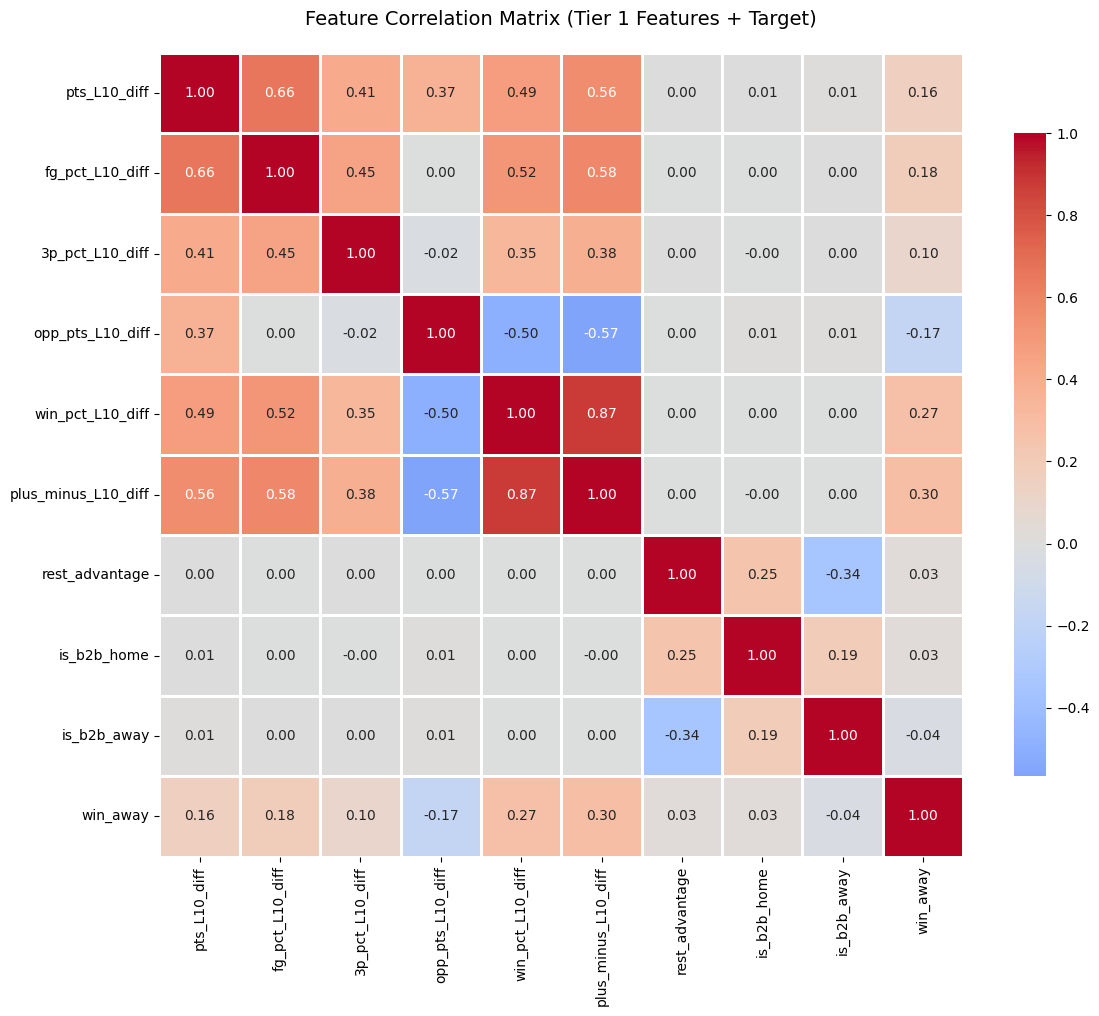


Note: Showing Tier 1 features only for readability.


In [20]:
# Correlation heatmap for Tier 1 features (keep it focused for readability)
plt.figure(figsize=(12, 10))
corr_matrix = matchups_clean[tier1_features + ['win_away']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix (Tier 1 Features + Target)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\nNote: Showing Tier 1 features only for readability.")


## 8. Save Processed Data

Save both the individual game data and the matchup dataset.


In [21]:
# Save the processed game data (with rolling features)
games_clean = games.dropna(subset=['pts_L10'])
games_clean.to_csv('nba_games_with_features.csv', index=False)
print(f"✓ Saved: nba_games_with_features.csv ({len(games_clean):,} rows)")

# Save the matchup dataset (ready for modeling)
matchups_clean.to_csv('nba_matchups_with_features.csv', index=False)
print(f"✓ Saved: nba_matchups_with_features.csv ({len(matchups_clean):,} rows)")

print("\n" + "="*70)
print("DATA WRANGLING COMPLETE!")
print("="*70)



✓ Saved: nba_games_with_features.csv (70,017 rows)
✓ Saved: nba_matchups_with_features.csv (34,952 rows)

DATA WRANGLING COMPLETE!


---

## Summary

**What we did:**
1. ✓ Loaded game data from `team_traditional.csv`
2. ✓ Calculated rolling features (last 10 games) using point-in-time data (`.shift(1)` to prevent leakage)
3. ✓ Added contextual features (rest days, back-to-backs, win streaks)
4. ✓ Created matchup dataset combining home and away team features
5. ✓ Calculated differentials (home - away) for each feature
6. ✓ Cleaned data 
7. ✓ Saved processed datasets

**Output files:**
- `nba_games_with_features.csv` - Individual game data with rolling features
- `nba_matchups_with_features.csv` - Matchup data ready for modeling

**Tier 1 Features (9 core features):**
1. `pts_L10_diff` - Point differential
2. `fg_pct_L10_diff` - Field goal % differential
3. `3p_pct_L10_diff` - Three-point % differential
4. `opp_pts_L10_diff` - Defensive strength differential
5. `win_pct_L10_diff` - Win % differential
6. `plus_minus_L10_diff` - Point differential (from box score)
7. `rest_advantage` - Rest days differential
8. `is_b2b_home` - Home team on back-to-back
9. `is_b2b_away` - Away team on back-to-back

**Tier 2 Features (10 advanced features):**
1. `efg_pct_L10_diff` - Effective FG% differential
2. `ts_pct_L10_diff` - True shooting % differential
3. `3pa_rate_L10_diff` - 3-point attempt rate differential
4. `ast_L10_diff` - Assists differential
5. `tov_L10_diff` - Turnovers differential
6. `reb_L10_diff` - Rebounds differential
7. `stl_L10_diff` - Steals differential
8. `blk_L10_diff` - Blocks differential
9. `pts_std_L10_diff` - Point volatility differential
10. `win_streak_diff` - Win streak differential

**Total: 19 features for modeling**

**Target variable:** `win_home` (1 = away team wins, 0 = home team wins)


In [22]:
# Quick peek at final dataset structure
print("Final matchup dataset structure:")
print(f"Shape: {matchups_clean.shape}")
print(f"\nSample with Tier 1 features:")
matchups_clean[['date', 'team_home', 'team_away', 'win_away'] + tier1_features[:5]].head(3)


Final matchup dataset structure:
Shape: (34952, 118)

Sample with Tier 1 features:


,date,team_home,team_away,win_away,pts_L10_diff,fg_pct_L10_diff,3p_pct_L10_diff,opp_pts_L10_diff,win_pct_L10_diff
0,1996-11-02,ATL,DET,1.0,14.000000,8.600000,5.000000,-5.000000,1.000000
1,1996-11-12,ATL,CLE,0.0,-2.000000,1.963333,-3.190000,-8.000000,0.300000
2,1996-11-15,ATL,MIA,0.0,4.392857,2.503571,-7.317857,3.571429,0.214286


Next step: Filter dataset down to which seasons we want to use. 